## Energy Use Analysis and Forecast

Dataset Source: https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import seaborn as sns
sns.set_theme(style = "darkgrid")

# ignore warnings while running code 
import warnings
warnings.filterwarnings("ignore")

### Load Input File 

In [2]:
path = r'/Users/akhilmathur/Desktop/python_files/datasets/house_power_consumption.txt'
df= pd.read_csv(path, sep = ";")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
# we rename the columns for easier interpretation
new_cols = ['Date', 'Time', 'active_power_W', 'reactive_power_W', 
            'voltage_V', 'current_A', 'kitchen_energy_WH', 
            'laundry_energy_WH' ,'heating_cooling_WH'
           ]
df.columns = new_cols 

# for some reason the expected float columns are also in object dtype - check for special characters in these columns 
# it appears that ? character is present across column - good chance its causing issue with other columns too - let's remove it 
for column in df.columns[2:-1]:
    df[column] = df[column].astype(str)
    df[column] = df[column].replace(['?'], np.nan)
    df[column] = df[column].astype(float)

# use forward fill to impute missing data
df.fillna(method = 'ffill',inplace = True)

In [4]:
df.describe().round(2)

,active_power_W,reactive_power_W,voltage_V,current_A,kitchen_energy_WH,laundry_energy_WH,heating_cooling_WH
count,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00
mean,1.09,0.12,240.84,4.60,1.11,1.29,6.42
std,1.05,0.11,3.24,4.43,6.12,5.79,8.42
min,0.08,0.00,223.20,0.20,0.00,0.00,0.00
25%,0.31,0.05,239.00,1.40,0.00,0.00,0.00
50%,0.60,0.10,241.02,2.60,0.00,0.00,1.00
75%,1.52,0.19,242.87,6.40,0.00,1.00,17.00
max,11.12,1.39,254.15,48.40,88.00,80.00,31.00


In [5]:
# median for both kitchen and laundry energy use is 0 - what % of the rows in these columns are 0 

for column in ['kitchen_energy_WH','laundry_energy_WH','heating_cooling_WH']:
    print(f"{column}:{100*round((df[df[column] == 0].shape[0]/df[column].shape[0]),2)}%")

kitchen_energy_WH:92.0%
laundry_energy_WH:70.0%
heating_cooling_WH:41.0%


In [6]:
# extract year, month, day, hour from a datetime column 
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df['year'] = df['datetime'].dt.year 
df['month'] = df['datetime'].dt.month 
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek

# extract weekday/weekend category label from day_of_week (0-4: weekday, 5-6: weekend) 
def flag_week(x):
    if x < 5:
        return 'weekday'
    else:
        return'weekend'
df['day_type'] = df['day_of_week'].apply(lambda x: flag_week(x))

# remove redundant rows 
df.drop(['Date','Time'], axis = 'columns', inplace = True)

In [7]:
# can we get occupancy ???
df[(df.kitchen_energy_WH == 0) & (df.laundry_energy_WH == 0) & (df.heating_cooling_WH == 0)]

,active_power_W,reactive_power_W,voltage_V,current_A,kitchen_energy_WH,laundry_energy_WH,heating_cooling_WH,datetime,year,month,day,hour,day_of_week,day_type
292,2.358,0.000,237.10,9.8,0.0,0.0,0.0,2006-12-16 22:16:00,2006,12,16,22,5,weekend
293,0.960,0.054,238.68,5.6,0.0,0.0,0.0,2006-12-16 22:17:00,2006,12,16,22,5,weekend
294,1.606,0.000,238.76,7.8,0.0,0.0,0.0,2006-12-16 22:18:00,2006,12,16,22,5,weekend
295,2.350,0.000,238.59,9.8,0.0,0.0,0.0,2006-12-16 22:19:00,2006,12,16,22,5,weekend
296,2.428,0.068,238.87,10.0,0.0,0.0,0.0,2006-12-16 22:20:00,2006,12,16,22,5,weekend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075254,0.946,0.000,240.43,4.0,0.0,0.0,0.0,2010-11-26 20:58:00,2010,11,26,20,4,weekday
2075255,0.944,0.000,240.00,4.0,0.0,0.0,0.0,2010-11-26 20:59:00,2010,11,26,20,4,weekday
2075256,0.938,0.000,239.82,3.8,0.0,0.0,0.0,2010-11-26 21:00:00,2010,11,26,21,4,weekday
2075257,0.934,0.000,239.70,3.8,0.0,0.0,0.0,2010-11-26 21:01:00,2010,11,26,21,4,weekday


### Outlier Handling

<Figure size 640x480 with 0 Axes>

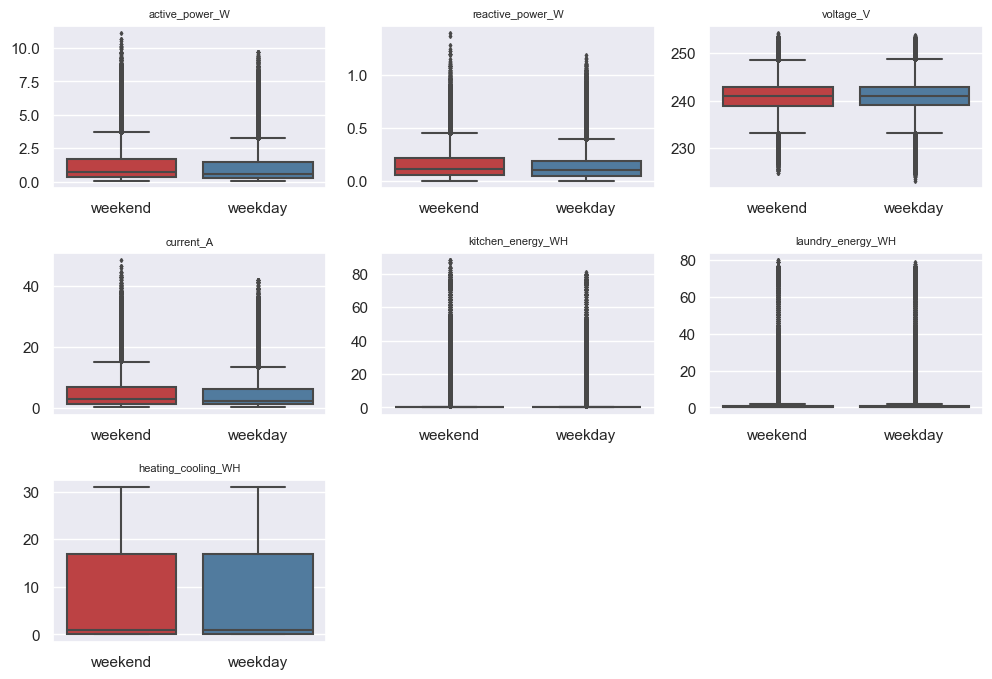

In [8]:
plt.figure() 

def get_subplots(df_input,cols):
    nrows, ncols = 3 , 3
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(12, 8))
    plt.subplots_adjust(hspace=0.4)
    
    cols_lst = list(cols)
    cols_idx = 0 
    
    for i in range(nrows):
        for j in range(ncols):
            if cols_idx == len(cols_lst):
                fig.delaxes(axes[i][j])
            else:
                sns.boxplot(
                     x='day_type', y= cols_lst[cols_idx] , data= df_input, 
                     ax = axes[i][j],palette = 'Set1', saturation = 0.6,
                     fliersize = 2          
                )
                axes[i][j].set(ylabel="")
                axes[i][j].set(xlabel="")
                axes[i][j].set_title(cols_lst[cols_idx], fontsize=8)
                cols_idx += 1

feature_cols = df.columns[:-7]
get_subplots(df,feature_cols)


# identify and filter out outliers using the IQR method
# data = df[feature_cols]

# Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
# IQR = Q3 - Q1
# lb, ub = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# # Identify and filter out outliers
# outliers_mask = ~((data < lb) | (data > ub)).any(axis=1)
# df_new = df[outliers_mask] 

# get_subplots(df_new,feature_cols)

### Aggregation and Visualization

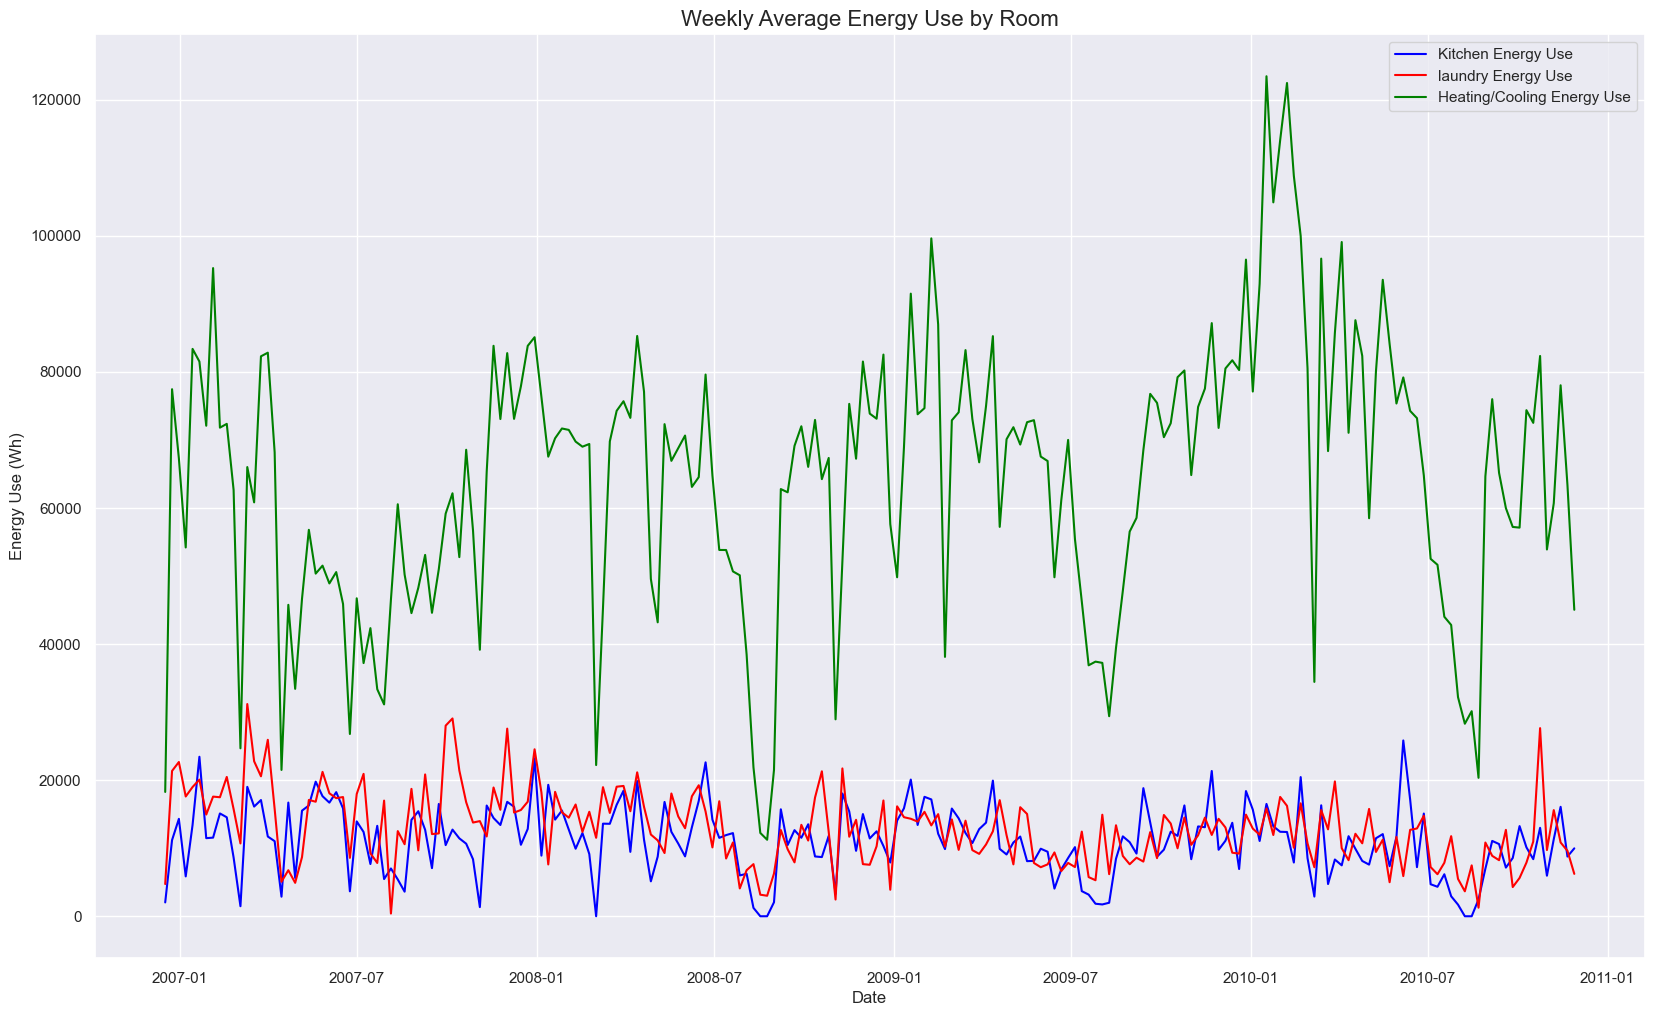

In [9]:
plt.figure(figsize = (20,12))
# df_daily = df.groupby(['year','month'])[['kitchen_energy_WH','laundry_energy_WH','heating_cooling_WH']].agg('sum').reset_index()

df_daily = df.resample('W', on = 'datetime').sum()

sns.lineplot(x = 'datetime', y = 'kitchen_energy_WH', data = df_daily, label = 'Kitchen Energy Use', color = 'blue')
sns.lineplot(x = 'datetime', y = 'laundry_energy_WH', data = df_daily, label = 'laundry Energy Use', color = 'red' )
sns.lineplot(x = 'datetime', y = 'heating_cooling_WH', data = df_daily, label = 'Heating/Cooling Energy Use', color = 'green')

plt.title('Weekly Average Energy Use by Room', fontsize=16)
plt.xlabel('Date')
plt.ylabel("Energy Use (Wh)")
plt.show()

In [11]:
# aggreate data to hourly level - note that the energy use will be summed over the hour while rate features like power will be averaged 
grpby_cols = ['year','month','day_type','day','hour']
aggs, aggs_type = dict() , ('mean','mean','mean','mean','sum','sum','sum')

for column,agg in zip(df.columns[:-6], aggs_type):
    aggs[column] = agg
    
df_hour = df.groupby(grpby_cols).aggregate(aggs).reset_index()
# df_hour = df.resample('H', on = 'datetime').aggregate(aggs).reset_index()

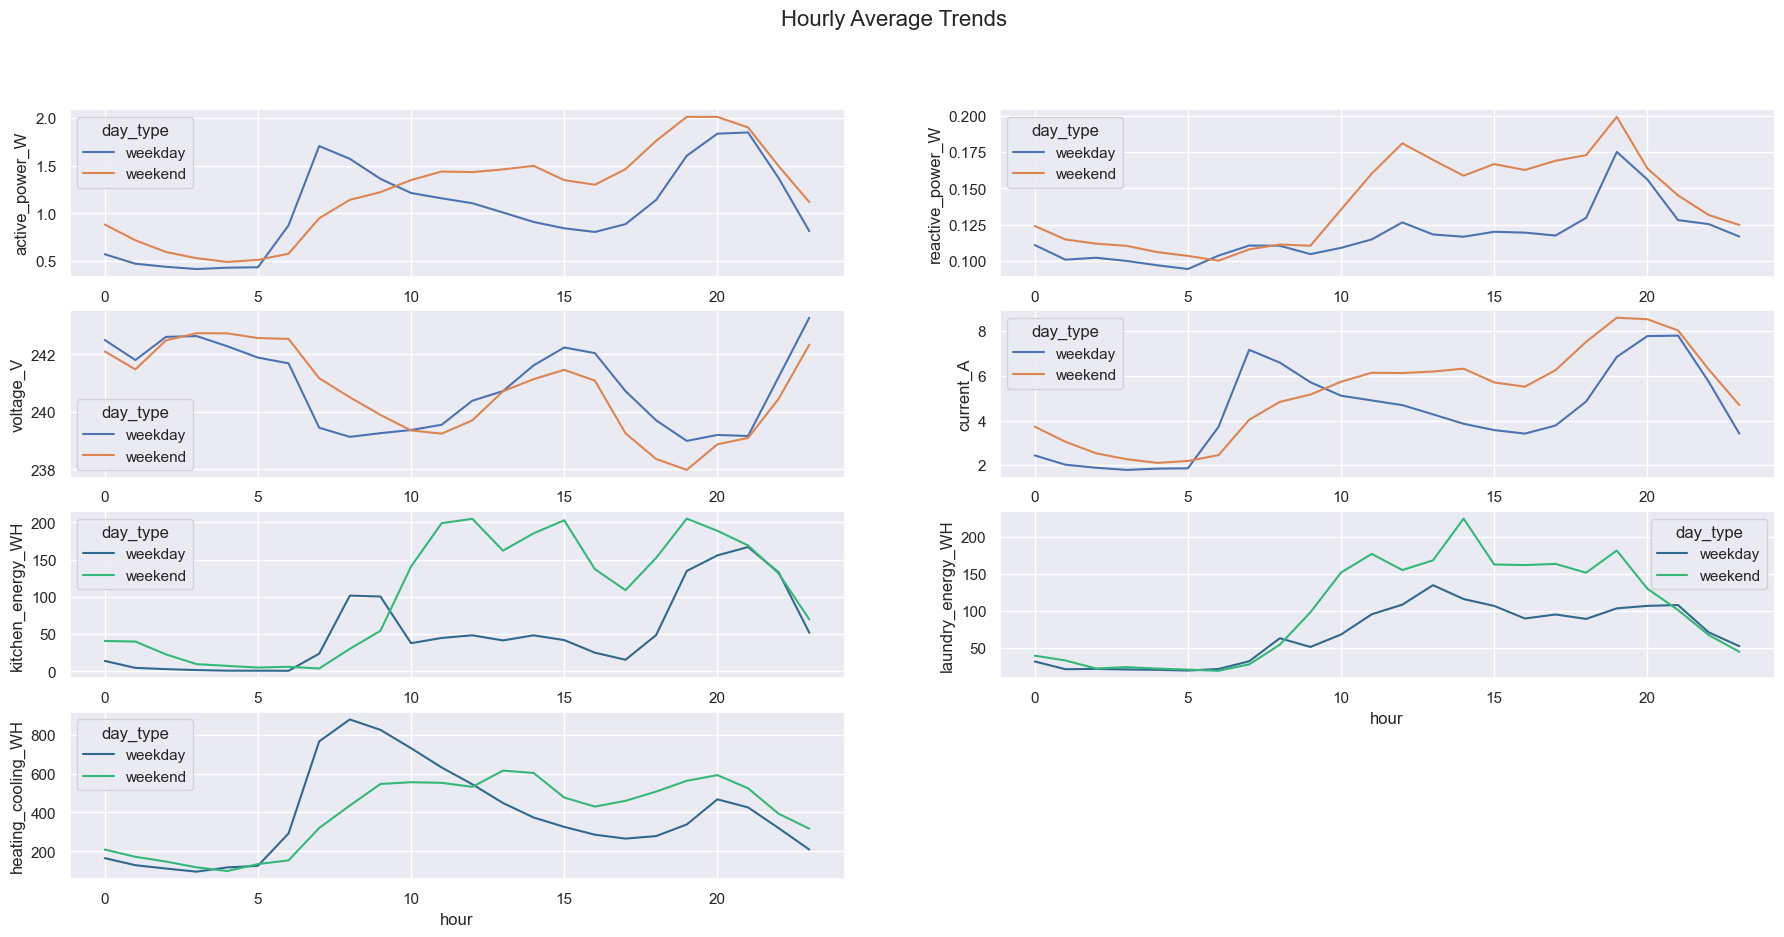

In [12]:
# generate subplot for each feature in dataset 
fig, axes = plt.subplots(4,2, figsize = (22,10))
plt.suptitle('Hourly Average Trends', fontsize=16)  # Adjust the fontsize as needed
col_idx = 5

for i in range(0,4):
    for j in range(0,2):
        if col_idx in range(9,12):
            palette = "viridis"
        else:
            palette = None
        if col_idx == 5+7:
            fig.delaxes(axes[i][j])            
        else:
            agg = df_hour.groupby(['hour','day_type'])[df_hour.columns[col_idx]].agg('mean').to_frame().reset_index()
            sns.lineplot(x='hour', y= df_hour.columns[col_idx], data=agg , ax = axes[i][j], hue = 'day_type', palette = palette)
            col_idx += 1

In [26]:
# create new column for total energy use across all rooms 
df['total_energy_use_WH'] =  df.kitchen_energy_WH + df.laundry_energy_WH + df.heating_cooling_WH

# to create stacked bar chart showing per-room consumption - lets melt the df to get new column for room type 
df_temp = df[df.columns[4:-1]]
df_temp.drop(['datetime'], axis = 'columns', inplace = True)
df_temp_melt = pd.melt(df_temp, id_vars = ['year', 'month', 'day', 'hour','day_of_week', 'day_type'], var_name = 'Room', value_name = 'Energy_Use_kWh')
df_temp_melt['Energy_Use_kWh'] = df_temp_melt['Energy_Use_kWh']/1000

df_dow = df_temp_melt.groupby(['day_of_week','Room'])['Energy_Use_kWh'].agg('sum').reset_index()
plt.figure(figsize=(10, 6)) 

# generate the barplot showing daily energy use by room
ax = sns.barplot(x = 'day_of_week', y = 'Energy_Use_kWh', data = df_dow, hue = 'Room')
custom_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax.set_xlabel('')
ax.set_ylabel('Energy Use (kWh)')
ax.set_xticklabels(custom_labels)
ax.set_title('Total Daily Energy Use by Room (2006-2010)')
plt.show()

In [55]:
# association of total energy use with the different parameters - its simple equations!
df_num = df.select_dtypes(exclude = 'object')
df_num.corr()['total_energy_use_WH']

active_power_W         0.847314
reactive_power_W       0.181197
voltage_V             -0.338516
current_A              0.844303
kitchen_energy_WH      0.570054
laundry_energy_WH      0.531584
heating_cooling_WH     0.743281
datetime               0.008035
year                   0.015943
month                 -0.031295
day                   -0.006569
hour                   0.165009
day_of_week            0.044267
total_energy_use_WH    1.000000
Name: total_energy_use_WH, dtype: float64

### Power/Energy Consumption Forecasting

#### Machine Learning Model

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


features = ['active_power_W', 'reactive_power_W', 'voltage_V', 'current_A',
       'month', 'day', 'hour', 'day_of_week']

target = ['total_energy_use_WH']


X = np.asarray(df[features])
y = np.asarray(df[target])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 123)

# create dictionary to store results for different training models 
res_models = pd.DataFrame(columns = ['RMSE','R2 Score'])


# function to compute model evaluation metrics 
def evaluate_model(model_name, y_test, y_pred):
    # calculate RMSE value 
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    # calculate R2 square 
    r2 = r2_score(y_test, y_pred).round(5)
    # append results to final dataframe 
    res_models.loc[model_name] = [rmse,r2]

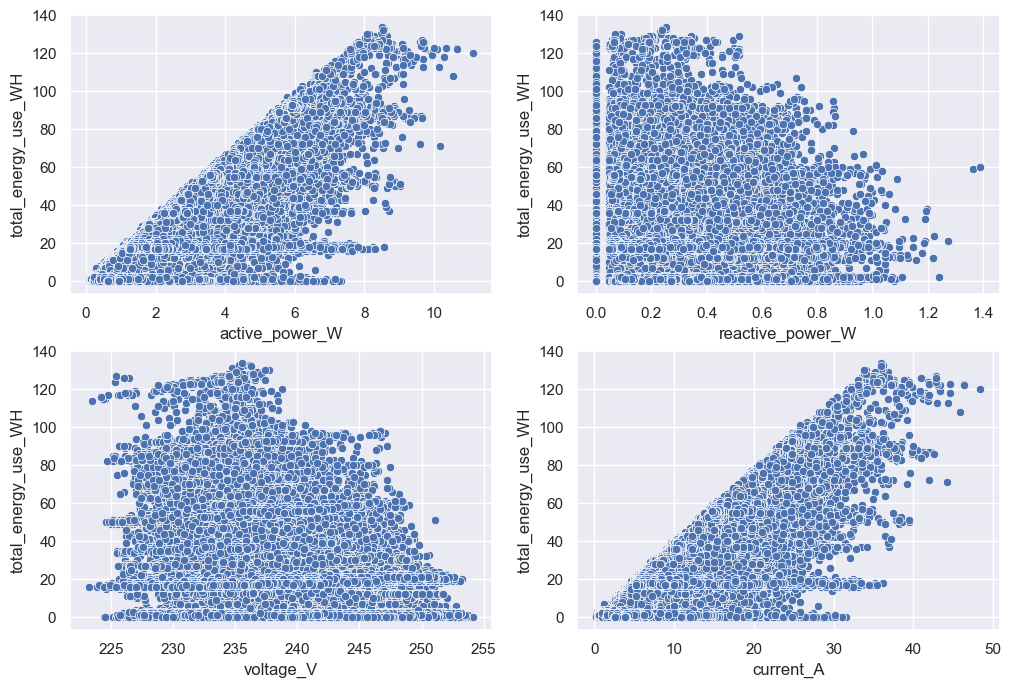

In [58]:
# The relationship between V,I,P and E is mathematically known- lets create scatter plot to visualize the same 

# remove 0 energy values for clearer rep

fig, axes = plt.subplots(2,2, figsize = (12,8))
col_idx = 0

for i in range(2):
    for j in range(2):
        sns.scatterplot(x=features[col_idx],y='total_energy_use_WH',data=df, ax = axes[i][j])
        col_idx += 1 

In [73]:
# let us start with a simple linear regression model to evaluate to what extent it can capture 
from sklearn.linear_model import LinearRegression, Ridge, Lasso

lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

evaluate_model('Linear Regression', y_test, y_pred)

In [44]:
# K-Nearest Neighbors 
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

evaluate_model('KNN', y_test, y_pred)

Average K-Fold CV Accuracy for KNeighborsRegressor(n_neighbors=15) is :0.937


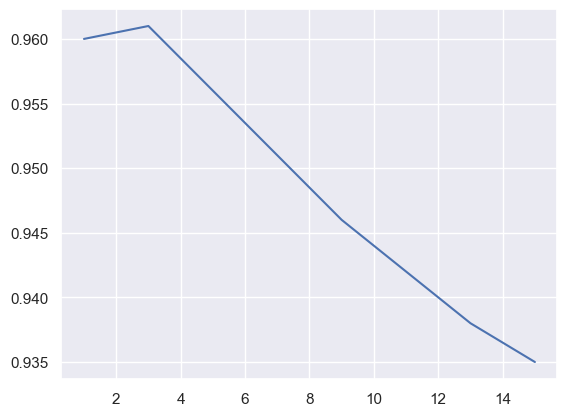

In [97]:
# run 5-fold Cross Validation to further confirm the KNN model performance 
from sklearn.model_selection import KFold, cross_val_score 

n_folds = 5 
model = knn

kf = KFold(n_splits=n_folds, shuffle=True, random_state=1234)
cv_res = cross_val_score(knn, X, y, cv=kf, scoring='r2')

print(f"Average K-Fold CV Accuracy for {model} is :{cv_res.mean().round(3)}")


# check the model performance for different 'k' neighbor values 
knn_res = pd.DataFrame(columns = ['R2'])

for k in range(1,16,2):
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    r2 = r2_score(y_test, y_pred).round(3)
    knn_res.loc[k] = [r2]

plt.plot(knn_res)

In [92]:
# Random Forest (Ensemble Method) - generally good at uncovering complex relationships between features 
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 50, random_state = 123)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test) 

evaluate_model('Random Forest', y_test, y_pred)

In [96]:
res_models.sort_values(by = 'R2 Score').round(3)

,RMSE,R2 Score
Linear Regression,6.720,0.725
Random Forest,2.640,0.958
KNN,2.521,0.961
